In [1]:
using Polynomials, PyPlot, QuadGK, LinearAlgebra

# Dot products of functions

We can apply the Gram–Schmidt process to *any* vector space as long as we **define a dot product** (also called an **inner product**).   (Technically, a continuous ("complete") vector space equipped with an inner product is called a **Hilbert space**.)

For column vectors, the usual dot product is to multiply the components and add them up.

But (real-valued) *functions* $f(x)$ also define a vector space (you can add, subtract, and multiply by constants).  In particular, consider functions defined on the interval $x \in [-1,1]$.   The "components" of $f$ can be viewed as its *values* $f(x)$ at each point in the domain, and the obvious analogue of "summing the components" is the **integral**.   Hence, the most obvious "dot product" of two functions in this space is:

$$
f \cdot g = \int_{-1}^1 f(x) g(x) \, dx
$$

Such a generalized inner product is commonly denoted $\langle f, g \rangle$ (or $\langle f | g \rangle$ in physics).

This satisfies the [key properties](https://en.wikipedia.org/wiki/Inner_product_space#Elementary_properties) of dot products that make linear algebra "work":

* **symmetry**: $f \cdot g = g \cdot f$
* **linearity**: $f \cdot (\alpha g + \beta h) = \alpha (f\cdot g) + \beta (f \cdot h)$
* **positivity**: $f \cdot f = \Vert f \Vert^2 \ge 0$, and $=0$ only if $f = 0$ ([almost everywhere](https://en.wikipedia.org/wiki/Almost_everywhere)).

As long as the dot product has these properties, much of what we do in 18.06 will "just work" for functions too.  **Gram–Schmidt will just work**.

# Orthogonal polynomials

In particular, let us consider a subspace of functions defined on $[-1,1]$: **polynomials** $p(x)$ (of any degree).

One possible basis of polynomials is simply:

$$
{1, x, x^2, x^3, \ldots}
$$

(There are infinitely many polynomials in this basis because this vector space is **infinite-dimensional**.)

Instead, let us apply Gram–Schmidt to this basis in order to get an **orthogonal basis of polynomials** known as the [Legendre polynomials](https://en.wikipedia.org/wiki/Legendre_polynomials).

## Julia code

I'll use the [Polynomials package](https://github.com/Keno/Polynomials.jl) to do polynomial arithmetic for me.

However, I'll need to define a few extra methods to perform my dot products from above, and I also want to display ("pretty print") the polynomials a bit more nicely than the default.

In [2]:
# compute the dot product ⟨p,q⟩ = ∫p(x)q(x) on [-1,1]
polydot(p::Polynomial, q::Polynomial) = integrate(p*q, -1,1)

polydot (generic function with 1 method)

In [3]:
# force IJulia to display as LaTeX rather than HTML
Base.showable(::MIME"text/html", ::Polynomial) = false

In [4]:
Polynomial([3,4,5,6])

Polynomial(3 + 4*x + 5*x^2 + 6*x^3)

In [5]:
Polynomial([3,4,5,6])^2

Polynomial(9 + 24*x + 46*x^2 + 76*x^3 + 73*x^4 + 60*x^5 + 36*x^6)

## Gram–Schmidt on polynomials

Now, let's apply Gram–Schmidt on the polynomials $a_i = x^i$ for $i = 0, 1, \ldots$.

Ordinarily, in Gram–Schmidt, I would normalize each result $p(x)$ by dividing by $\Vert p \Vert = \sqrt{p \cdot p}$, but that will result in a lot of annoying square roots.  Instead, I will divide by $p(1)$ to result in the more conventional Legendre polynomials.  **This is not an "orthonormal" basis because we have chosen a different normalization, but it is still an *orthogonal* basis.**

That means that to get $p_i(x)$, I will do:

$$
v_i(x) = a_i(x) - \sum_{j=0}^{i-1} p_j(x) \frac{p_j \cdot a_i}{p_j \cdot p_j}
$$

We would get an ordinary orthnormal basis of polynomials with

$$
q_i(x) = v_i(x) / \Vert v_i \Vert
$$

but instead we will use the Legendre normalization

$$
p_i(x) = v_i(x) / v_i(1)
$$


where I explicitly divide by $p_i \cdot p_i$ in the projections to compensate for the lack of normalization.

In Julia, I will use the special syntax `2 // 3` to construct the exact rational $\frac{2}{3}$, etc.  This will allow me to see the exact Legendre polynomials without any roundoff errors or annoying decimals.

In [6]:
p0 = a0 = Polynomial([1//1])

Polynomial(1//1)

In [7]:
a1 = Polynomial([0, 1//1])

Polynomial(x)

In [8]:
p1 = a1 - p0 * polydot(p0, a1) // polydot(p0, p0)
p1 = p1 / p1(1)

Polynomial(x)

In [9]:
polydot(p0, a1)

0//1

Orthogonalization didn't change $x$, because $x$ and $1$ are already orthogonal under this dot product.  In fact, any even power of $x$ is orthogonal to any odd power (because the dot product is the integral of an even function times an odd function).

On the other hand, $x^2$ and $1$ are *not* orthogonal, so orthogonalizing them leads to a *different* polynomial of degree 2:

In [10]:
a2 = Polynomial([0, 0, 1//1])

Polynomial(x^2)

In [11]:
p2 = a2 - p0 * polydot(p0, a2) // polydot(p0, p0) -
          p1 * polydot(p1, a2) // polydot(p1, p1)
p2 = p2 / p2(1)

Polynomial(-1//2 + 3//2*x^2)

It quickly gets tiresome to type in these expressions one by one, so let's just write a function to compute the Legendre polynomials $p_0, \ldots, p_n$:

In [12]:
function legendre_gramschmidt(n)
    legendre = [Polynomial([1//1])]
    for i = 1:n
        p = Polynomial([k == i ? 1//1 : 0//1 for k=0:i])
        for q in legendre
            p = p - q * (polydot(q, p) // polydot(q,q))
        end
        push!(legendre, p / p(1))
    end
    return legendre
end

legendre_gramschmidt (generic function with 1 method)

In [13]:
L = legendre_gramschmidt(5)

6-element Vector{Polynomial{Rational{Int64}, :x}}:
 Polynomial(1//1)
 Polynomial(x)
 Polynomial(-1//2 + 3//2*x^2)
 Polynomial(-3//2*x + 5//2*x^3)
 Polynomial(3//8 - 15//4*x^2 + 35//8*x^4)
 Polynomial(15//8*x - 35//4*x^3 + 63//8*x^5)

Let's display them more nicely with LaTeX:

In [14]:
display.(L);

Polynomial(1//1)

Polynomial(x)

Polynomial(-1//2 + 3//2*x^2)

Polynomial(-3//2*x + 5//2*x^3)

Polynomial(3//8 - 15//4*x^2 + 35//8*x^4)

Polynomial(15//8*x - 35//4*x^3 + 63//8*x^5)

Key things to notice:

* The polynomials contain *only even* or *only odd* powers of $x$, but not both.  The reason is that the even and odd powers of $x$ are *already* orthogonal under this dot product, as noted above.

* A key property of Gram–Schmidt is that the **first k vectors span the same space** as the **original first k vectors**, for any k.   In this case, it means that $p_0, \ldots, p_k$ span the same space as $1, x, \ldots, x^k$.  That is, the $p_0, \ldots, p_k$ polynomials are an **orthogonal basis for all polynomials of degree k or less**.

These polynomials are **very special** in many ways.  To get a hint of that, let's plot them:

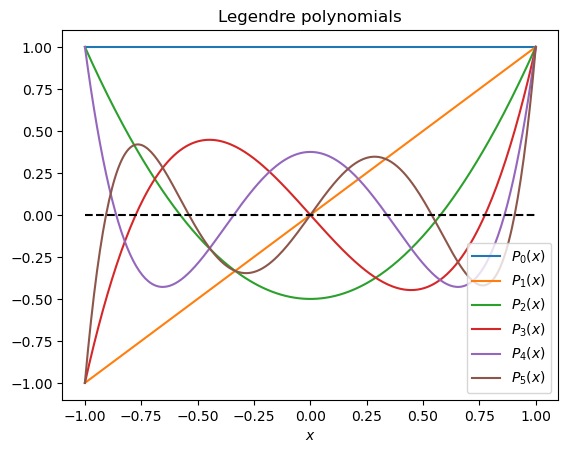

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /Users/stevenj/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


PyObject Text(0.5, 1.0, 'Legendre polynomials')

In [15]:
leg = []
x = range(-1, 1, length=300)
for i in eachindex(L)
    plot(x, L[i].(x), "-")
    push!(leg, L"P_{%$(i-1)}(x)")
end
plot(x, x * 0, "k--")
legend(leg)
xlabel(L"x")
title("Legendre polynomials")

Note that $p_n(x)$ has exactly $n$ roots in the interval $[-1,1]$!

This is essentially required by the fact that they are orthogonal: $p_n$ has to oscillate in sign faster and faster in $[-1,1]$ as $n$ increases in order to integrate to zero against the previous polynomials.

### Expanding a polynomial in the Legendre basis.

Now that we have an orthogonal (but not orthonormal) basis, it is easy to take an arbitrary polynomial $p(x)$ and write it in this basis:

$$
    p(x) = \alpha_0 p_0(x) + \alpha_1 p_1(x) + \cdots = \sum_{i=0}^\infty \alpha_i p_i(x)
$$

because we can get the coefficients $\alpha_i$ merely by projecting:

$$
\alpha_i = \frac{p_i \cdot p}{p_i \cdot p_i}
$$

Note, however, that this isn't actually an infinite series: if the polynomial $p(x)$ has degree $d$, then $\alpha_i = 0$ for $i > d$.  The polynomials $p_0, \ldots, p_d$ are a basis for the subspace of polynomials of degree $d$ (= span of $1, x, \ldots, x^d$)!

Let's see how this works for a "randomly" chosen $p(x)$ of degree 5:

In [16]:
p = Polynomial([1,3,4,7,2,5])

Polynomial(1 + 3*x + 4*x^2 + 7*x^3 + 2*x^4 + 5*x^5)

Here are the coefficients α:

In [17]:
α = [polydot(q,p)/polydot(q,q) for q in L]

6-element Vector{Rational{Int64}}:
  41//15
 327//35
  80//21
 226//45
  16//35
  40//63

Let's check that the sum of $\alpha_i p_i(x)$ gives $p(x)$:

In [18]:
sum(α .* L) # α[1]*L[1] + α[2]*L[2] + ... + α[6]*L[6]

Polynomial(1//1 + 3//1*x + 4//1*x^2 + 7//1*x^3 + 2//1*x^4 + 5//1*x^5)

In [19]:
sum(α .* L) - p

Polynomial(0//1)

## Polynomial fits

### Review: Projections and Least-Square

Given a matrix $Q$ with $n$ orthonormal columns $q_i$, we know that the **orthogonal projection** 

$$
p = QQ^T b = \sum_{i=1}^n q_i q_i^T b
$$

is the **closest vector** in $C(Q)$ to $b$.  That is, it **minimizes** the distance:

$$
\min_{p \in C(Q)} \Vert p - b \Vert \; .
$$

### Closest polynomials

Now, suppose that we have some function $f(x)$ on $x\in[-1,1]$ that is *not* a polynomial, and we want to find the **closest polynomial** of degree $n$ to $f(x)$ in the least-square sense.  That is, we want to find the polynomials $p(x)$ of degree $n$ that **minimizes**

$$
\min_{p\in \mathcal{P}_n} \int_{-1}^1 |f(x)-p(x)|^2 dx = 
\min_{p\in \mathcal{P}_n} \Vert f(x) - p(x) \Vert^2
$$

where

$$
\mathcal{P}_n = \operatorname{span} \{ 1, x, x^2, \ldots, x^n \}
= \operatorname{span} \{ p_0(x), p_1(x), \ldots, p_n(x) \}
$$

is the space of polynomials of degree $\le n$, spanned by our Legendre polynomials up to degree $n$.

Presented in this context, we can see that this is *the same problem*  as our least-square problem above, and the solution should be the same: $p(x)$ is the **orthogonal projection** of $f(x)$ onto $\mathcal{P}_n$, given by:

$$
p(x) = p_0(x) \frac{p_0 \cdot f}{p_0 \cdot p_0} + \cdots 
       p_n(x) \frac{p_n \cdot f}{p_n \cdot p_n} \; .
$$

Let's try this out for $f(x) = e^x$.  Because we're lazy, we'll have Julia compute the integrals numerically using its `quadgk` function, and fit it to polynomials of degree 5 using our Legendre polynomials from above.

In [20]:
polydot(p::Polynomial, f::Function) = quadgk(x -> p(x)*f(x), -1,1, atol=1e-13, rtol=1e-11)[1]

polydot (generic function with 2 methods)

Now, let's use dot products to compute the coefficients in the $p_i(x)$ expansion above for $f(x) = e^x$ (the `exp` function in Julia):

In [21]:
coeffs = [polydot(p,exp)/polydot(p,p) for p in L]

6-element Vector{Float64}:
 1.1752011936438014
 1.1036383235143268
 0.35781435064737244
 0.07045563366848885
 0.00996512814886882
 0.0010995861272082227

One thing to notice is an important fact: expanding functions, especially [smooth functions](https://en.wikipedia.org/wiki/Smoothness), in orthogonal bases like Legendre polynomials or Fourier series tends to converge very rapidly.

Let's write out the resulting polynomial $p(x)$:

In [22]:
p = sum(coeffs .* L)

Polynomial(1.000030941375941 + 1.000016597000109*x + 0.49935229541280063*x^2 + 0.16651770555815018*x^3 + 0.043597435651301086*x^4 + 0.008659240751764753*x^5)

Let's plot it:

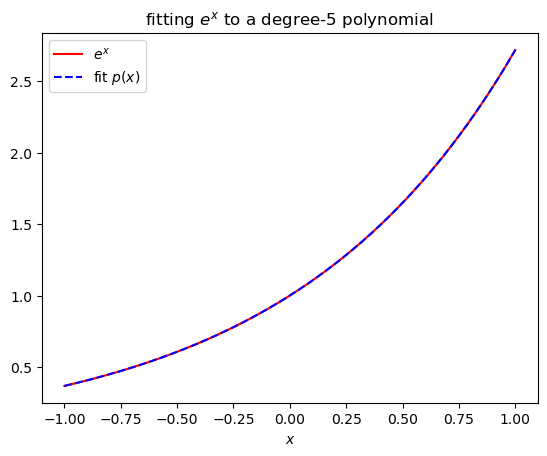

PyObject Text(0.5, 1.0, 'fitting $e^x$ to a degree-5 polynomial')

In [23]:
plot(x, exp.(x), "r-")
plot(x, p.(x), "b--")
legend([L"e^x", L"fit $p(x)$"])
xlabel(L"x")
title(L"fitting $e^x$ to a degree-5 polynomial")

They are so close that you can hardly tell the difference!

Let's plot the fits for degree 0, 1, …, 3 so that we can watch it converge:

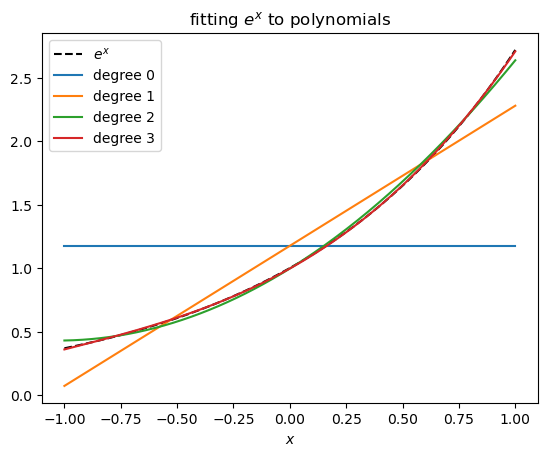

PyObject Text(0.5, 1.0, 'fitting $e^x$ to polynomials')

In [24]:
plot(x, exp.(x), "k--")
for n = 1:4
    plot(x, sum([polydot(p,exp)/polydot(p,p) for p in L[1:n]] .* L[1:n]).(x), "-")
end
legend([L"e^x", ["degree $i" for i=0:3]...])
xlabel(L"x")
title(L"fitting $e^x$ to polynomials")

By degree 3, it is hard to tell the difference from $e^x$.

### Fitting a non-smooth function

It may not be so surprising that we can fit $e^x$ to polynomials; after all, $e^x$ has a convergent Taylor series, which is also a polynomial. But what we try to fit a *non-smooth* function, such as a **triangle-shape function** $t(x)$?  That is,


$$
t(x) = 1 - |x|
$$

(a triangle peaked at $x=0$ and zero at $x=\pm 1$).  Let's see:

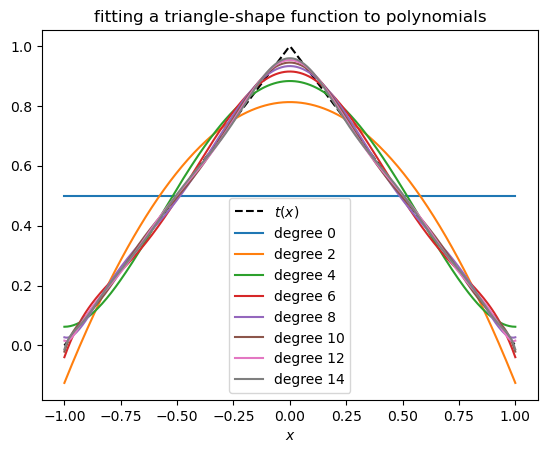

PyObject Text(0.5, 1.0, 'fitting a triangle-shape function to polynomials')

In [25]:
t(x) = 1 - abs(x)

L16 = legendre_gramschmidt(16) # compute a few more terms

plot(x, t.(x), "k--")
N = [1:2:16;]
for n in N
    plot(x, sum([polydot(p,t)/polydot(p,p) for p in L16[1:n]] .* L16[1:n]).(x), "-")
end
legend([L"t(x)", ["degree $i" for i in N .- 1]...])
xlabel(L"x")
title("fitting a triangle-shape function to polynomials")

It is still converging, just much more slowly!